### Reading important libraries for reading, analyzing and visualizing data

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.utils import compute_class_weight, compute_sample_weight
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier, XGBRFClassifier
import xgboost as xgb

from keras.preprocessing import text, sequence
from keras.models import Model
from keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalAveragePooling1D, Embedding, BatchNormalization, MaxPool1D, Activation
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
# Reading training dataframe and displaying top 10 rows
train_df = pd.read_csv('train.csv')
train_df.head()

,Review Text,Review Title,topic
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture


In [3]:
# Reading test dataframe and displaying top 10 rows
test_df = pd.read_csv('test.csv')
test_df.head()

,Review Text,Review Title
0,I use chia seed in my protein shakes. These ta...,Bad tast
1,I use chia seed in my protein shakes. These ta...,Bad tast
2,Don’t waste your money.,No change. No results.
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"


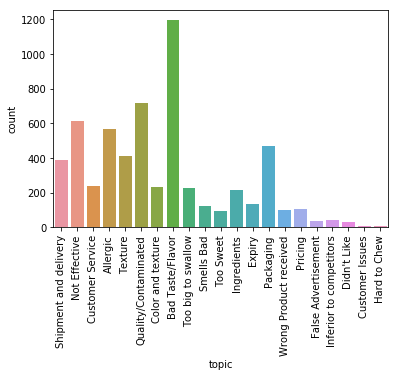

In [11]:
# Displaying the count of all 21 labels appearing in train_df
sns.countplot(train_df['topic'])
plt.xticks(rotation=90)
plt.show()

In [4]:
# Now let us transform labels from text to integer labels
le = LabelEncoder()
tr_lbls = le.fit_transform(train_df['topic'])
tr_lbls.shape

(5959,)

### Now since we have a Multilabel Classification problem to solve, but our dataset is provided in form of a Multiclass classification format, with some reviews occuring more than once with different labels, we should squeeze it to change its format to multilabel classification problem

In [7]:
# Defining function to check whether review at idx1 is same as that at idx2
def isSameReview(df, idx1, idx2):
        
    if df.iloc[idx1, 1].strip() != df.iloc[idx2, 1].strip():
        return False
    else:
        if df.iloc[idx1, 0].strip() != df.iloc[idx2, 0].strip():
            return False
        
    return True

In [8]:
# Checking in train_df which all are same reviews to reduce redundancy using above util function
idx = 0
tr_titles = []
tr_reviews = []
tr_labels = []
tr_idx_list = [idx]

while idx < len(train_df):
    tr_titles.append(train_df.iloc[idx, 1])
    tr_reviews.append(train_df.iloc[idx, 0])
    labels = [tr_lbls[idx]]
    
    while idx<(len(train_df)-1) and isSameReview(idx, idx+1):
        #print (idx)
        labels.append(tr_lbls[idx+1])
        idx += 1
        
    tr_labels.append(labels)
    idx += 1
    tr_idx_list.append(idx)
    #print (idx)
    #print ('------------------------------------')

In [6]:
# Checking in test_df which all are same reviews to reduce redundancy using above util function
idx = 0
te_titles = []
te_reviews = []
te_idx_list = [idx]

while idx < len(test_df):
    te_titles.append(test_df.iloc[idx, 1])
    te_reviews.append(test_df.iloc[idx, 0])
    
    while idx<(len(test_df)-1) and isSameReview(idx, idx+1):
        #print (idx)
        idx += 1
        
    idx += 1
    te_idx_list.append(idx)
    #print (idx)
    #print ('------------------------------------')

In [9]:
# Now we need to combine titles and reviews from train_df and test_df, so that we can create a tf-idf corpus on all data
all_text = []

for idx in range(len(tr_titles)):
    all_text.append(tr_titles[idx] + ' ' + tr_reviews[idx])
    
for idx in range(len(te_titles)):
    all_text.append(te_titles[idx] + ' ' + te_reviews[idx])

len(all_text)

6000

### Now we need to clean our data                                                                                                                                   1.  We need to remove encodings as <> which are present in many reviews                                                                             2. Next we need to remove URL addresses which are outside the <>                                                                            3. We need to remove Video IDs mentioned in some of the reviews                                                                                   4. We also need to remove quotation marks

In [10]:
# Removing frequently present <br> tags from our corpus, this will also remove other useless HTML tags, if present
clean = re.compile('<.*?>')
for idx in range(len(all_text)):
    all_text[idx] = re.sub(clean, '', all_text[idx])

In [11]:
# Removing quotation marks from data, otherwise words like don't get tokenized as [don, t], which makes no sense
clean = re.compile(r"'|\"|’")
for idx in range(len(all_text)):
    all_text[idx] = re.sub(clean, '', all_text[idx])

In [12]:
# Removing Video ID links present in few reviews as these are just gibberish alphanumeric strings
clean = re.compile(r"\S+VIDEOID\S+")
for idx in range(len(all_text)):
    all_text[idx] = re.sub(clean, '', all_text[idx])

In [13]:
# Removing web links present in few reviews. In some weblinks there is a space present in "X BRAND", so I have first
# replaced "X BRAND" to "XBRAND" and then removed these weblinks
clean = re.compile(r"http.?://[^\s]+[\s]?")
for idx in range(len(all_text)):
    all_text[idx] = re.sub('X BRAND', 'XBRAND', all_text[idx])

for idx in range(len(all_text)):
    all_text[idx] = re.sub(clean, '', all_text[idx])

### Now since we have finished our data cleaning, we can proceed to create a Tf-Idf Vectorizer using a tokenizer, stopwords and a stemmer. The ouput of this Vectorizer will be a 2D sparse array that we can feed to a classifier, coupled with the label ground truths. Entries in this 2D sparse matrix represent the tf-idf scores for each token in a review

In [95]:
# We will be using a Regular-Expression Tokenizer, English stop-words list and Porter Stemmer from NLTK
regexp_tok = RegexpTokenizer('[A-Za-z]+')
stop_list = stopwords.words('english')[:100]
stemmer = PorterStemmer()

In [75]:
# Creating a new corpus of stemmed words which we will provide to Tf-Idf Vectorizer
stem_words = []
for i, txt in enumerate(all_text):
    tokens = regexp_tok.tokenize(txt)
    new_txt = ' '.join(stemmer.stem(tok) for tok in tokens)
    stem_words.append(new_txt)

len(stem_words)

6000

In [112]:
# Using Tf-Idf Vectorizer class from SkLearn which will transform our stemmed corpus to a 2D sparse matrix as explained above
tfidf = TfidfVectorizer(tokenizer=regexp_tok.tokenize, sublinear_tf=True)
all_arr = tfidf.fit_transform(all_text)
all_arr.shape

(6000, 10072)

In [79]:
tfidf.vocabulary_.keys()

dict_keys(['useless', 'did', 'noth', 'for', 'me', 'didnt', 'help', 'lost', 'even', 'with', 'work', 'out', 'and', 'eat', 'healthi', 'curb', 'appetit', 'or', 'anyth', 'trash', 'do', 'not', 'buy', 'these', 'bag', 'it', 'a', 'waist', 'of', 'time', 'i', 'have', 'bought', 'immedi', 'open', 'one', 'put', 'in', 'some', 'the', 'wa', 'split', 'down', 'side', 'so', 'anoth', 'to', 'cover', 'also', 'x', 'dont', 'you', 'will', 'end', 'up', 'throw', 'your', 'box', 'away', 'recommend', 'gave', 'an', 'allerg', 'reaction', 'on', 'my', 'face', 'cant', 'tackl', 'big', 'mess', 'compar', 'name', 'brand', 'wipe', 'famili', 'littl', 'kid', 'we', 'use', 'lot', 'cut', 'through', 'sticki', 'theyr', 'small', 'veri', 'thin', 'might', 'be', 'ok', 'less', 'often', 'place', 'but', 'good', 'at', 'actual', 'care', 'lemon', 'scent', 'felt', 'too', 'strong', 'tast', 'horribl', 'no', 'choke', 'hazard', 'are', 'extrem', 'hard', 'swallow', 'pill', 'huge', 'sharp', 'serious', 'feel', 'like', 'can', 'them', 'know', 'about', '

In [113]:
#Separating train and test arrays
X_train = all_arr[:len(tr_titles), :]
X_test = all_arr[len(tr_titles):, :]
print (X_train.shape, X_test.shape)

(4224, 10072) (1776, 10072)


In [99]:
# For Maultilabel classification, we need to prepare out train ground truth labels as a 2D array of ones and zeros, which
# is why we use MultiLabelBinarizer to convert 1D array (4224,) to 2D array (4224, 21)
multi_label = MultiLabelBinarizer()
y_train = multi_label.fit_transform(tr_labels)
y_train.shape

(4224, 21)

### Now since we have prepared our training data and training labels, we can proceed to Model Training. I have used and experimented on four models - Gradient Boosted trees using XgBoost, Random Forest Classifiers using XgBoost, NB-SVM (Naive-Bayes Support Vector Machine) and Bidirectional LSTMs.                                    
### For first 2 classifiers, I have used SkLearn's OneVsRest Classifier to convert them to MultiLabel Classifiers, however, NB-SVM and LSTMs can be used as they are.
### Also for first 2 classifiers, I have fixed there parameters after running a RandomSearchCV over a large variety of parameters. For NB-SVM and LSTM, I manually experimented with different hyper-parameter values and have fixed the currently used

In [30]:
# These is the parameter space used for both Gradient Boosted Tree and Random Forest for RandomSearchCV api
params = {
        'estimator__max_depth' : [3, 4, 5],                           # learning parameter
        'estimator__learning_rate': [0.3, 0.1, 0.05],                 # learning parameter
        'estimator__n_estimators': [100, 200, 300],                   # learning parameter
        'estimator__colsample_bytree': [0.6, 0.8, 1.0],               # regulazation parameter
        'estimator__reg_alpha': [1, 2, 3]                             # l1 regularization parameter
        }

In [32]:
# Training Gradient Boosted Tree using XgBoost and applying Random Search over above mentioned parameter space for 10
# iterations with 5 folds of CV. I ran above parameter space, in two folds, first checking only for the growth/learning
# parameters and second time checking for parameters which prevent Over-Sampling
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle = True, random_state = 1001)

xgb_clf = XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=5, verbosity=2, objective='multi:softprob', num_class=21)
onevsrest_clf = OneVsRestClassifier(xgb_clf, n_jobs=4)

random_search = RandomizedSearchCV(onevsrest_clf, param_distributions=params, scoring='f1_samples', cv=kf.split(X_train, y_train), verbose=3, random_state=1001)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] estimator__n_estimators=200, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.7min remaining:    0.0s


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.3, score=0.818174133558749, total=14.6min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 28.0min remaining:    0.0s


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.3, score=0.8010726026110642, total=13.2min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.3, score=0.8124786324786325, total=13.0min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.3, score=0.8252521837137222, total=13.1min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.3, score=0.8246689987211313, total=13.5min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.01, score=0.70236071620687, total=21.6min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.01, score=0.7046623462008077, total=21.4min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.01, score=0.7129322813938197, total=21.7min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.01, score=0.6955574340189725, total=21.5min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.01, score=0.7005228315654854, total=21.6min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.05, score=0.7762637362637363, total= 7.3min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.05, score=0.7647299708838171, total= 7.5min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.05, score=0.7747187001033156, total= 7.4min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.05, score=0.7713816098431484, total= 7.6min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.05, score=0.7791976980365606, total= 7.4min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.3, score=0.8126120033812342, total=18.8min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.3, score=0.7967727998497229, total=19.4min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.3, score=0.8092213769136847, total=19.2min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.3, score=0.8157058326289095, total=18.9min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.3, score=0.8187448281050177, total=20.0min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.05, score=0.8127636466098004, total=13.9min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.05, score=0.8007570207570208, total=13.6min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.05, score=0.805231520616136, total=13.7min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.05, score=0.8089771766694843, total=13.9min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.05, score=0.812034529451591, total=14.3min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.1, score=0.8204052357898511, total=13.5min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.1, score=0.807711092326477, total=13.2min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.1, score=0.8168291537522306, total=13.1min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.1, score=0.8235841081994928, total=13.7min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.1, score=0.8251466937485894, total=13.7min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.3, score=0.818658264812111, total= 7.1min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.3, score=0.8043796374565605, total= 6.9min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.3, score=0.8105456936226166, total= 6.9min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.3, score=0.8198872921949845, total= 6.9min
[CV] estimator__n_estimators=100, estimator__learning_rate=0.3 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=100, estimator__learning_rate=0.3, score=0.8211163770405475, total= 6.9min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.1, score=0.8214308768154922, total=20.1min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.1, score=0.812642058795905, total=19.6min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.1, score=0.8160120221658683, total=19.5min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.1, score=0.8251620174697099, total=28.2min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.1 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.1, score=0.8309260513051981, total=30.6min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.01, score=0.65141730064807, total=24.5min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.01, score=0.652140509063586, total=21.5min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.01, score=0.6630327791866254, total=21.5min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.01, score=0.6347228839536531, total=17.6min
[CV] estimator__n_estimators=200, estimator__learning_rate=0.01 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=200, estimator__learning_rate=0.01, score=0.6496934476792298, total=13.9min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.05, score=0.815603883296191, total=26.9min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.05, score=0.8103033718418333, total=20.0min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.05, score=0.817144735606274, total=17.7min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.05, score=0.8168779938010707, total=26.6min
[CV] estimator__n_estimators=300, estimator__learning_rate=0.05 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 819.0min finished


[CV]  estimator__n_estimators=300, estimator__learning_rate=0.05, score=0.8196569623109907, total=23.0min


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001911E376E08>,
          error_score='raise',
          estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       ...1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=2),
          n_jobs=4),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'estimator__learning_rate': [0.3, 0.1, 0.05, 0.01], 'estimator__n_estimators': [100, 200, 300]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='f1_samples', verbose=3)

In [114]:
# Training Gradient Boosted Tree classifier with best parameters found using above Random search
xgb_clf = XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=5, verbosity=2, objective='multi:softprob', num_class=21)
onevsrest_clf = OneVsRestClassifier(xgb_clf, n_jobs=4)
onevsrest_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None, num_class=21,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=2),
          n_jobs=4)

In [115]:
# Predicting over the Test Dataset using trained XgBoost model
preds_xgb = onevsrest_clf.predict_proba(X_test)

In [116]:
# Training Random Forest classifier with best parameters found using above Random search
xgb_rf_clf = XGBRFClassifier(learning_rate=0.1, n_estimators=300, max_depth=5, verbosity=2, objective='multi:softprob', num_class=21)
onevsrest_rf_clf = OneVsRestClassifier(xgb_rf_clf, n_jobs=4)
onevsrest_rf_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
        n_jobs=1, nthread=None, num_class=21, objective='multi:softprob',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=None, subsample=0.8, verbosity=2),
          n_jobs=4)

In [117]:
# Predicting over the Test Dataset using trained Random Forest model
preds_rf = onevsrest_rf_clf.predict_proba(X_test)

### Below I have tried Naive Bayes - Support Vector Machines

In [130]:
# This is the Naive-Bayes basic equation
def pr(y_i, y):
    p = X_train[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y):
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = X_train.multiply(r)
    return m.fit(x_nb, y), r

In [131]:
# We fit each label one at a time
nbsvm_preds = np.zeros((1776, 21))

for i in range(21):
    print ('fit '+str(i))
    m, r = get_mdl(y_train[:, i])
    nbsvm_preds[:, i] = m.predict_proba(X_test.multiply(r))[:, 1]

fit 0


AttributeError: 'numpy.ndarray' object has no attribute 'multiply'

### Below I have prepared a Keras Bidirectional LSTM model. All the hyper-parameters, embedding length of tokens, input size for each sentence, layer size, different types of layers like 1D Convolution with/without LSTM were tweaked manually. But I still found a normal Bidirectional LSTM model working best for this problem. I did not use pre-trained embeddings because generally they don't work well in case of small datasets, pertaining to the fact that the common tokens turn out to be very less, which reduces the performance further.

In [119]:
keras_tok = text.Tokenizer()
keras_tok.fit_on_texts(all_text)
new_all_texts = keras_tok.texts_to_sequences(all_text)
X = sequence.pad_sequences(new_all_texts, 200)
X_train = X[:len(tr_titles), :]
X_test = X[len(tr_titles):, :]
print (X_train.shape, X_test.shape)

(4224, 200) (1776, 200)


In [120]:
max_features = len(keras_tok.word_counts)
embed_size = 100
max_features

10722

In [123]:
train_idx = random.sample([i for i in range(4224)], int(0.9*4224))
valid_idx = list(set([i for i in range(4224)]) - set(train_idx))

X_tr = X_train[train_idx, :]
y_tr = y_train[train_idx, :]
X_val = X_train[valid_idx, :]
y_val = y_train[valid_idx, :]

print (X_tr.shape, y_tr.shape, X_val.shape, y_val.shape)

(3801, 200) (3801, 21) (423, 200) (423, 21)


In [124]:
inp = Input((200,))
embed = Embedding(max_features+1, embed_size, input_length=200)(inp)
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embed)
avg_pool = GlobalAveragePooling1D()(lstm)
dense = Dense(64, activation='relu')(avg_pool)
drop = Dropout(0.1)(dense)
out = Dense(21, activation='sigmoid')(dense)

lstm_model = Model(inp, out)
lstm_model.summary()

W0811 23:40:32.845762 12000 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 23:40:32.872495 12000 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 23:40:32.880112 12000 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 23:40:33.135438 12000 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 23:40:33.149546 12000 deprecation.py:506

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          1072300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          84480     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1365      
Total params: 1,166,401
Trainable params: 1,166,401
Non-trainable params: 0
_________________________________________________________________


In [125]:
def top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [126]:
lstm_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[top5])

W0811 23:40:56.492053 12000 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 23:40:56.521557 12000 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0811 23:40:56.536788 12000 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [127]:
hist = lstm_model.fit(X_tr, y_tr, batch_size=64, epochs=50, verbose=1, validation_data=(X_val, y_val), callbacks=[ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=0.0000001), EarlyStopping(patience=10, verbose=1, restore_best_weights=True)])

Train on 3801 samples, validate on 423 samples
Epoch 1/50
3801/3801 [==============================] - 81s 21ms/step - loss: 0.3625 - top5: 0.3773 - val_loss: 0.2134 - val_top5: 0.6596
Epoch 2/50
3801/3801 [==============================] - 75s 20ms/step - loss: 0.2134 - top5: 0.6514 - val_loss: 0.2129 - val_top5: 0.6147
Epoch 3/50
3801/3801 [==============================] - 70s 18ms/step - loss: 0.2132 - top5: 0.6354 - val_loss: 0.2130 - val_top5: 0.6619
Epoch 4/50
3801/3801 [==============================] - 80s 21ms/step - loss: 0.2127 - top5: 0.6464 - val_loss: 0.2121 - val_top5: 0.6147
Epoch 5/50
3801/3801 [==============================] - 80s 21ms/step - loss: 0.2120 - top5: 0.6456 - val_loss: 0.2106 - val_top5: 0.6619
Epoch 6/50
3801/3801 [==============================] - 78s 21ms/step - loss: 0.2107 - top5: 0.6627 - val_loss: 0.2112 - val_top5: 0.6336
Epoch 7/50
3801/3801 [==============================] - 76s 20ms/step - loss: 0.2082 - top5: 0.6625 - val_loss: 0.2086 - val_

KeyboardInterrupt: 

In [128]:
# Predictions for LSTM model
lstm_preds = lstm_model.predict(X_test, batch_size=64)

In [137]:
# Average predictions for all 4 models
preds_avg = (preds + preds_xgb + preds_rf + lstm_preds) / 4.0

#preds_geomean = (preds * preds_xgb * preds_rf * lstm_preds) ** 4.0

### Below I prepared a helper function which prepares a submission dataframe and saves it with provided name

In [138]:
def subm_df(preds, subm_file):
    
    new_preds = []
    for i in range(len(te_idx_list)-1):
        start_idx = te_idx_list[i]
        end_idx = te_idx_list[i+1]
        diff = end_idx - start_idx
        pred_idx = preds[i].argsort()[-diff:][::-1]
        for pred in pred_idx: new_preds.append(pred)
        
    test_preds = le.inverse_transform(new_preds)
    subm_df = pd.read_csv('test.csv')
    subm_df['topic'] = test_preds
    subm_df.to_csv(subm_file, index=False)

In [139]:
subm_df(preds_geomean, 'preds_avg.csv')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [140]:
preds_avg

array([[0.0259676 , 0.43909261, 0.03770643, ..., 0.02002454, 0.02000235,
        0.01255358],
       [0.04284434, 0.02483947, 0.01258211, ..., 0.01230513, 0.01710293,
        0.01687884],
       [0.04895935, 0.06284668, 0.02404781, ..., 0.03273235, 0.02678353,
        0.01814154],
       ...,
       [0.5602819 , 0.60670522, 0.02127513, ..., 0.01562155, 0.06931867,
        0.0138615 ],
       [0.08962463, 0.03897221, 0.01520684, ..., 0.01236469, 0.02083567,
        0.01408974],
       [0.01930879, 0.20055215, 0.03684748, ..., 0.02019732, 0.01813376,
        0.01376362]])